# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.\
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

## Задача

1. Построить модель для предсказания заказов такси на следующий час.
2. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## 1. Загрузка данных

### 1.1 Импорт необходимых для работы библиотек, метрик и утилит

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# импортируем функции из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# импорт моделей
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# предварительная обработка
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# кроссвалидация
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit
)

# метрики
from sklearn.metrics import mean_squared_error

# настройки
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams

# константа верхний регистр
RANDOM_STATE = 42

### 1.2 Загрузим данные

In [2]:
# загрузим данные
data_taxi = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\taxi.csv')

**Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»)**

### 1.3 Изучим данные в таблице

In [3]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head())
    display(data.tail())
    data.info()
    display(data.describe())
    print('\nРазмер таблицы:', data.shape)
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков в таблице:', data.isna().sum().sum())

In [4]:
# общая информация о данных
get_info(data_taxi)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Размер таблицы: (26496, 2)

Количество явных дубликатов: 0

Количество пропусков в таблице: 0


In [5]:
# сделаем дату индексом и переведм в объект datetime
data_taxi.set_index('datetime', inplace = True) 
data_taxi.index = pd.to_datetime(data_taxi.index)

In [6]:
# проверим
display(data_taxi.head())
data_taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# проверим последовательность данных
print(data_taxi.index.is_monotonic)

True


In [8]:
# седлаем ресемлинг по 1 часу и сохраним данные в переменную df
df = data_taxi.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Вывод 

1. Получены данные по количеству заказов такси за период март - август 2018.
2. Данные столбца "datetime" переведены в тип данных Datetime, сам столбец установлен как индекс таблицы.
3. Пропусков в данных нет, временные данные последовательны, частота сбора информации каждые 10 минут.
4. Для дальнейшей работы данные ресемплированы по 1 часу.

## 2. Анализ данных

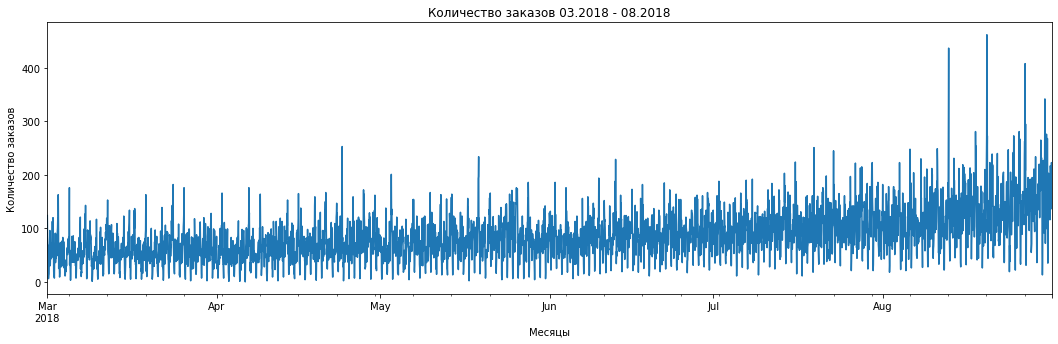

In [9]:
# построим график изменения количества заказов по времени
ax = df.plot(figsize = (18,5), legend = None)
ax.set(title = 'Количество заказов 03.2018 - 08.2018', xlabel = 'Месяцы', ylabel = 'Количество заказов');

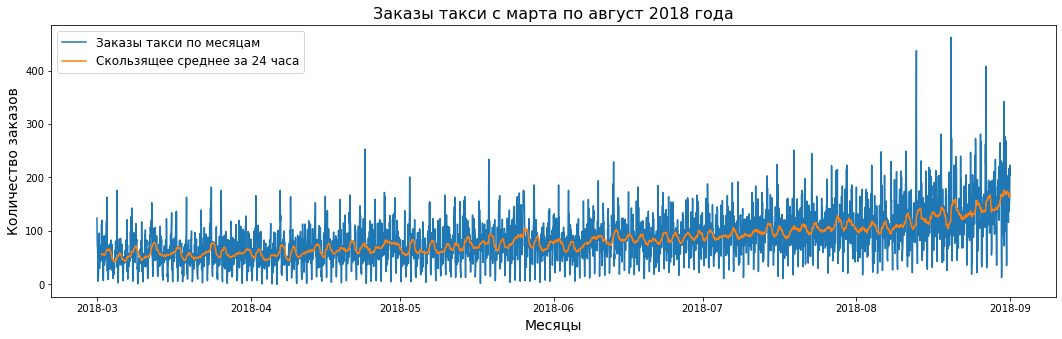

In [10]:
# график заказов и скользящее среднее за 24 часа
plt.figure(figsize = (18,5))

# легенда
plt.plot(df, label = 'Заказы такси по месяцам')
plt.plot(df.rolling(window=24).mean(), label = 'Скользящее среднее за 24 часа')
plt.legend(title = '', loc = 'upper left', fontsize = 12)

# заголовки и подписи к осям
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Заказы такси с марта по август 2018 года', fontsize = 16)

plt.show()

### 2.1 Декомпозиция временного ряда

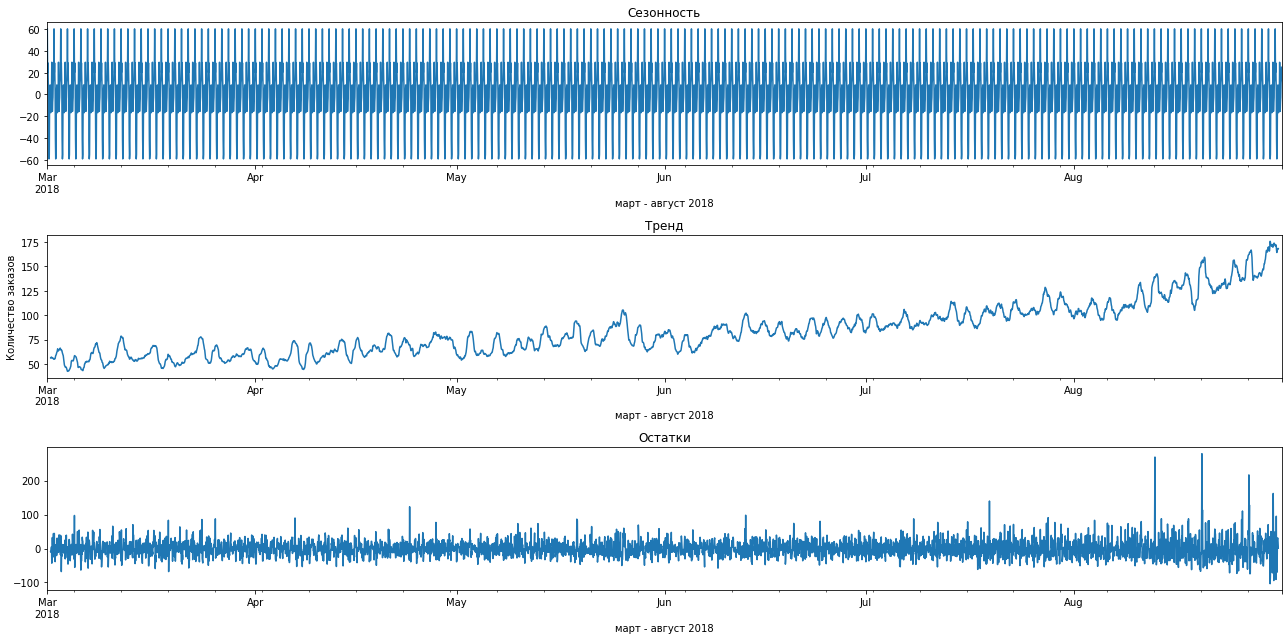

In [11]:
# сделаем декомпозицию временного ряда на тренд и сезонность для всего периода
decompose = seasonal_decompose(df)

# построим тренд, сезонность и остаточный график для всего периода
fig, axis = plt.subplots(3,1, figsize=(18,9))

decompose.seasonal.plot(ax=axis[0], title ='Сезонность', xlabel='март - август 2018')
decompose.trend.plot(ax=axis[1], title ='Тренд', xlabel='март - август 2018', ylabel='Количество заказов')
decompose.resid.plot(ax=axis[2], title ='Остатки', xlabel='март - август 2018')

plt.tight_layout()
plt.show()

#### Месяц

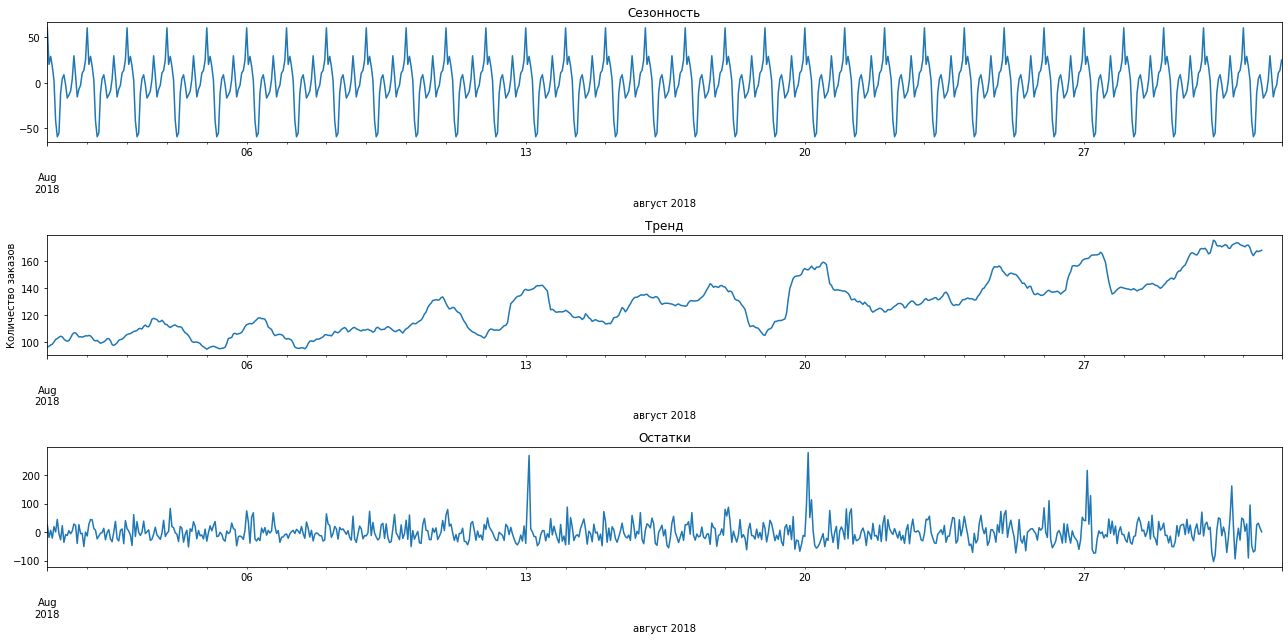

In [12]:
# построим тренд, сезонность и остаточный график для для августа
fig, axis = plt.subplots(3,1, figsize=(18,9))

decompose.seasonal['2018-08-01':'2018-08-31'].plot(ax=axis[0], title ='Сезонность', xlabel='август 2018')
decompose.trend['2018-08-01':'2018-08-31'].plot(ax=axis[1], title ='Тренд', xlabel='август 2018', ylabel='Количество заказов')
decompose.resid['2018-08-01':'2018-08-31'].plot(ax=axis[2], title ='Остатки', xlabel='август 2018')

plt.tight_layout()
plt.show()

#### Неделя (пн-вс)

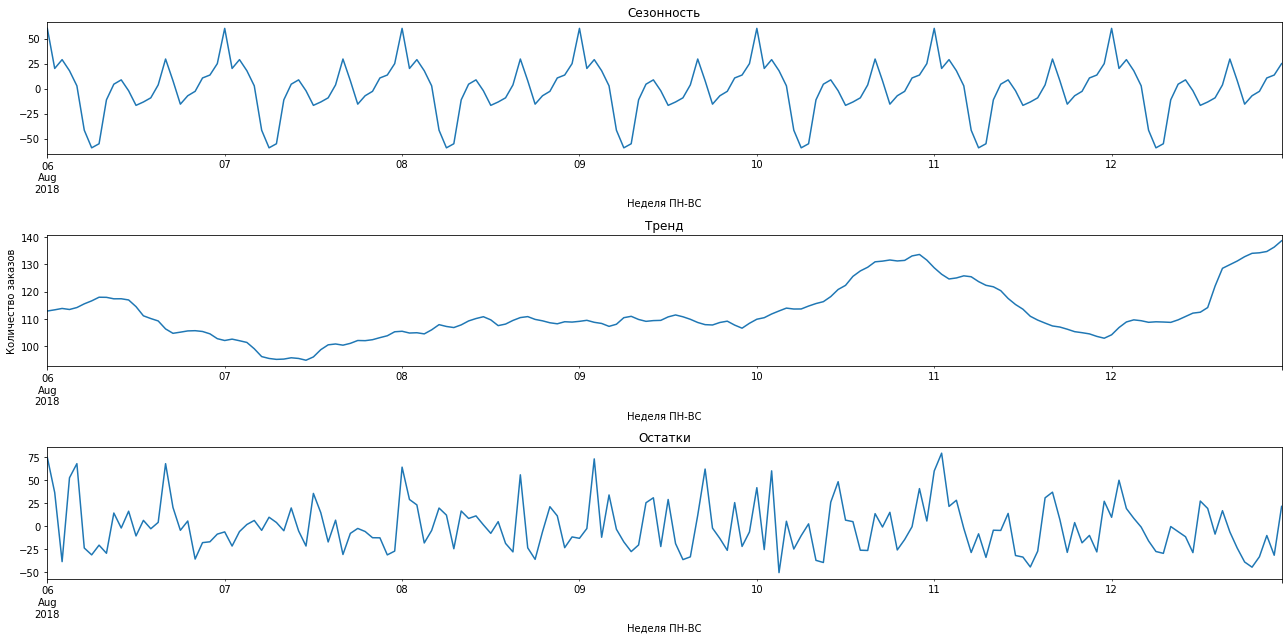

In [13]:
# построим тренд, сезонность и остаточный график для недельного временного промежутка
fig, axis = plt.subplots(3,1, figsize=(18,9))

decompose.seasonal['2018-08-06':'2018-08-12'].plot(ax=axis[0], title ='Сезонность', xlabel='Неделя ПН-ВС')
decompose.trend['2018-08-06':'2018-08-12'].plot(ax=axis[1], title ='Тренд', xlabel='Неделя ПН-ВС', ylabel='Количество заказов')
decompose.resid['2018-08-06':'2018-08-12'].plot(ax=axis[2], title ='Остатки', xlabel='Неделя ПН-ВС')

plt.tight_layout()
plt.show()

#### День (пт-сб)

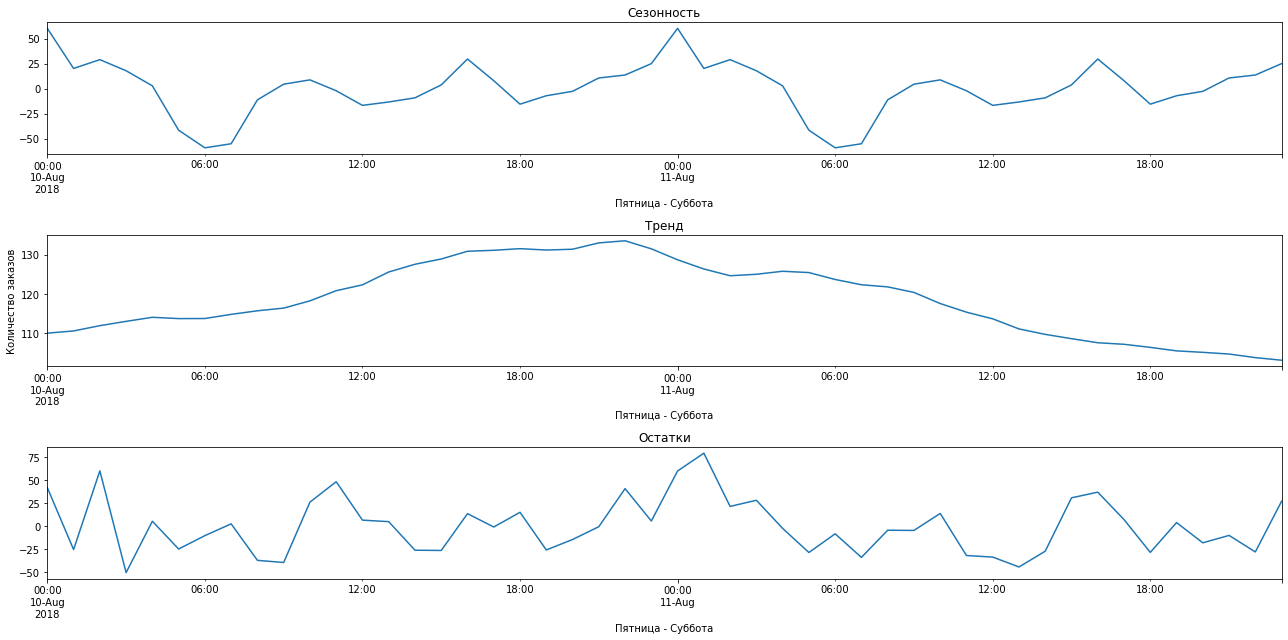

In [14]:
# построим тренд, сезонность и остаточный график для 2-х дневного временного промежутка
fig, axis = plt.subplots(3,1, figsize=(18,9))

decompose.seasonal['2018-08-10':'2018-08-11'].plot(ax=axis[0], title ='Сезонность', xlabel='Пятница - Суббота')
decompose.trend['2018-08-10':'2018-08-11'].plot(ax=axis[1], title ='Тренд', xlabel='Пятница - Суббота', ylabel='Количество заказов')
decompose.resid['2018-08-10':'2018-08-11'].plot(ax=axis[2], title ='Остатки', xlabel='Пятница - Суббота')

plt.tight_layout()
plt.show()

### 2.2 Проверка временного ряда на стационарность

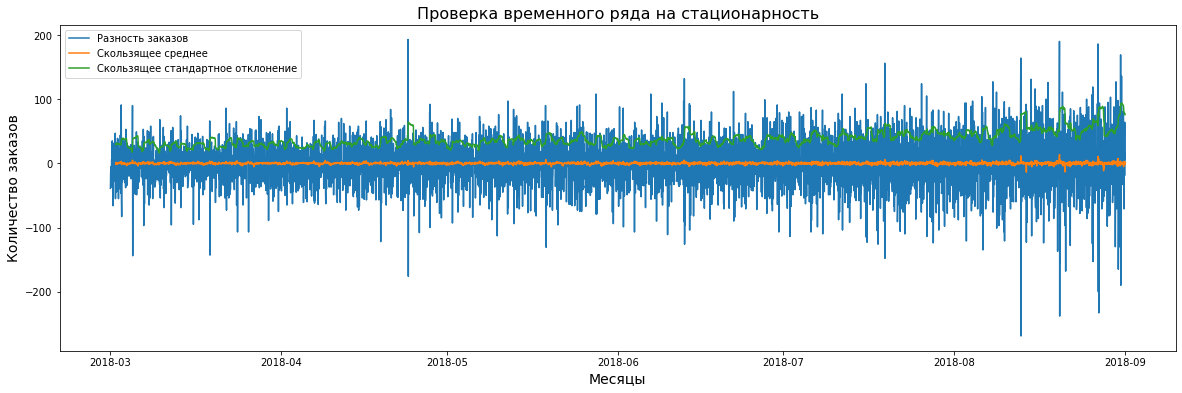

In [15]:
# найдем разности временного ряда
df_new = df - df.shift()
plt.figure(figsize = (20,6))

# легенда
plt.plot(df_new['num_orders'], label = 'Разность заказов')
plt.plot(df_new['num_orders'].rolling(24).mean(), label = 'Скользящее среднее')
plt.plot(df_new['num_orders'].rolling(24).std(), label = 'Скользящее стандартное отклонение')
plt.legend(title = '', loc = 'upper left', fontsize = 10)

# заголовки и подписи к осям
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Проверка временного ряда на стационарность', fontsize = 16)

plt.show()

### 2.3 Тест Дики-Фуллера

In [16]:
# зададим пороговое значение, равное 0,05
p_value = 0.05 

# передадим столбец с данными о заказах в "adfuller" и сохраним результат в adf_test
adf_test = adfuller(df['num_orders'])

# вывод p-value
print('\033[1m'+'p-value = '+'\033[0m' + str(adf_test[1]))
print('='*30)
if adf_test[1] < p_value:
    print('Стационарный ряд')
else:
    print('Нестационарный ряд')

p-value = 0.028940051402613094
Стационарный ряд


## Вывод 

1. Сделана декомпозиция временного ряда для оценки тренда и сезонности:
* наблюдаем тренд к увеличению заказов с марта по август 2018
* есть недельная сезонность заказов - рост количества заказов в пятницу и субботу
* отмечена суточная сезонность - увеличение заказов в вечерние и ночные часы
2. Временной ряд проверен на стационарность тестом Дики-Фуллера:
* имеем дело со стационарным временным рядом

## 3. Подготовка данных

### 3.1 Создадим признаки

In [17]:
df.shape

(4416, 1)

In [18]:
# создадим признаки для обучения моделей
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['weekday'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # вычислим отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)# 
    # вычислим скользящее среднее и добавим его как признак 'rolling_mean'.
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


# зададим отстающие признаки и скользящее среднее
make_features(df, 24, 24)
# результат
df.head()

,num_orders,month,day,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# удалим пропуски
df.dropna(inplace=True)
df.head()

,num_orders,month,day,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [20]:
df.shape

(4392, 30)

### 3.2 Разделим выборки и извлечем признаки

* train - обучающая выборка (90% исходных данных)
* test - тестовая выборка (10% исходных данных)

In [21]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [22]:
# выделим признаки
features = df.drop(['num_orders'], axis=1)                           
target = df['num_orders']                                            

# разделим на тренировочную - 90% и тестовую - 10% выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, shuffle=False, random_state=RANDOM_STATE
)

In [23]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_test.shape, '\n', 'Целевой признак:', y_test.shape, sep='')

Обучающая выборка
Признаки:(3952, 29)
Целевой признак:(3952,)
Тестовая выборка
Признаки:(440, 29)
Целевой признак:(440,)


In [24]:
# проверим последовательность временных данных после разделения на выборки
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())
print('='*40)
print(X_train.index.is_monotonic)
print(X_test.index.is_monotonic)
print(y_train.index.is_monotonic)
print(y_test.index.is_monotonic)

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00
True
True
True
True


## 4. Обучение моделей

* LinearRegression
* RandomForestRegressor
* CatBoostRegressor
* LGBMRegressor

In [25]:
# численные признаки
num_features = X_train.select_dtypes(exclude='object').columns
num_features

Index(['month', 'day', 'weekday', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object')

In [26]:
# валидатор временных рядов TimeSeriesSplit
splits = TimeSeriesSplit()

### 4.1 Модель "Linear Regression"

In [27]:
# признаки для Линейной регрессии
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [28]:
# масштабируем числовые признаки
transformer_lr = make_column_transformer((StandardScaler(), num_features),
                                        remainder = 'passthrough', verbose_feature_names_out=False
                                        )

In [29]:
# создадим модель (без масштабирования модель работает лучше)
model_lr = make_pipeline(LinearRegression())

In [30]:
# определяем параметры для перебора в GridSearchCV
parametrs_lr  = {} 

In [31]:
%%time
# передаем модель, параметры и оценку в GridSearchCV
lr  = GridSearchCV(
    model_lr,
    param_grid=parametrs_lr,
    cv=splits,
    verbose=True,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)
# обучим на тренировочных данных

lr.fit(X_train_lr, y_train)
# найдем лучший RMSE
rmse_lr = lr.best_score_*-1

print('\033[1m'+ 'Модель "Linear Regression"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_lr)
print('='*30)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Модель "Linear Regression"
RMSE: 26.94663475761977
CPU times: total: 62.5 ms
Wall time: 3.02 s


### 4.2 Модель "Random Forest Regressor"

In [32]:
# признаки для Регрессии случайного леса 
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [33]:
# масштабируем числовые признаки
transformer_rf = make_column_transformer((StandardScaler(), num_features),
                                         remainder = 'passthrough', verbose_feature_names_out=False)

In [34]:
# создадим модель
model_rf = make_pipeline(transformer_rf, RandomForestRegressor(random_state=RANDOM_STATE))

In [35]:
# определяем параметры для RandomizedSearchCV
parametrs_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
               }

In [36]:
%%time
# обучим модель и найдем лучшие параметры
rf = RandomizedSearchCV(
    model_rf,
    cv=splits,
    param_distributions=parametrs_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf.fit(X_train_rf, y_train)
rmse_rf = rf.best_score_*-1

print('\033[1m'+ 'Модель "Random Forest Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_rf)
print('='*75)
print("Лучшие параметры для Random Forest Regressor: \n", rf.best_params_)
print('='*75)

Модель "Random Forest Regressor"
RMSE: 25.31287720372103
Лучшие параметры для Random Forest Regressor: 
 {'randomforestregressor__n_estimators': 250, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_depth': 12}
CPU times: total: 12.5 s
Wall time: 37.6 s


### 4.3 Модель "Cat Boost Regressor"

In [37]:
# признаки для Регрессии КэтБуст
X_train_cbr = X_train.copy()
X_test_cbr = X_test.copy()

In [38]:
# создадим модель и передадим ей категориальные признаки
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, 
                              verbose=False, 
                              cat_features=[]) 

In [39]:
# параметры для подбора
parameters_cbr = [{'learning_rate':[0.1, 0.5, 0.8],
               'depth':[6,8,10],
               'iterations':[30, 50, 100],
               'verbose':[False]}]

In [40]:
%%time
# подберем лучшие параметры для модели CatBoostRegressor
grid_cbr = GridSearchCV(
    estimator=model_cbr,
    param_grid = parameters_cbr,
    cv=splits,
    verbose=True,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_cbr.fit(X_train_cbr, y_train)
rmse_cbr = grid_cbr.best_score_* -1

print('\033[1m'+ 'Модель "CatBoost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_cbr)
print('='*75)
print("Лучшие параметры для CatBoost Regressor:\n", grid_cbr.best_params_)
print('='*75)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Модель "CatBoost Regressor"
RMSE: 24.871952462913683
Лучшие параметры для CatBoost Regressor:
 {'depth': 6, 'iterations': 100, 'learning_rate': 0.1, 'verbose': False}
CPU times: total: 3.8 s
Wall time: 2min 6s


### 4.4 Модель "LightGBM Regressor"

In [41]:
# признаки для Регресси ЛайтГМБ 
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

In [42]:
# создадим модель
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE) 

In [43]:
# параметры для подбора
parameters_lgb = {'n_estimators': [100, 500, 1000],
                  'num_leaves':[31, 100, 200],
                  'learning_rate':[0.1, 0.3, 0.5]}

In [44]:
%%time
# подберем лучшие параметры для модели LGBMRegressor
grid_lgb = GridSearchCV(estimator=model_lgb,
                        param_grid=parameters_lgb,
                        scoring='neg_root_mean_squared_error',
                        cv=splits,
                        verbose=True,
                        n_jobs=-1)

grid_lgb.fit(X_train_lgb, y_train)
rmse_lgb = grid_lgb.best_score_* -1

print('\033[1m'+ 'Модель "LightGBM Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_lgb)
print('='*75)
print("Лучшие параметры для LightGBM Regressor:\n", grid_lgb.best_params_)
print('='*75)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Модель "LightGBM Regressor"
RMSE: 25.147296341896002
Лучшие параметры для LightGBM Regressor:
 {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
CPU times: total: 1.84 s
Wall time: 1min 15s


### 4.5 RMSE моделей на обучающей выборке

In [45]:
# таблица RMSE моделей на обучающей выборке
index_result =['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBMRegressor']
data_result = {'RMSE на обучающей выборке':[rmse_lr, rmse_rf, rmse_cbr, rmse_lgb]}

result = pd.DataFrame(data=data_result, index=index_result)
result

,RMSE на обучающей выборке
LinearRegression,26.946635
RandomForestRegressor,25.312877
CatBoostRegressor,24.871952
LightGBMRegressor,25.147296


## 5. Тестирование лучшей модели

### 5.1 Модель "CatBoost Regressor"

In [46]:
# создадим модель
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, 
                              verbose=False, 
                              cat_features=[]) 

In [47]:
# лучшие параметры
best_parameters_cbr = [{'learning_rate':[0.1],
               'depth':[6],
               'iterations':[100],
               'verbose':[False]}]

In [48]:
%%time
# обучим лучшую модель CatBoostRegressor
grid_cbr = GridSearchCV(
    estimator=model_cbr,
    param_grid = best_parameters_cbr,
    cv=splits,
    verbose=True,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_cbr.fit(X_train_cbr, y_train)
best_model_cbr = grid_cbr.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 2.19 s
Wall time: 1.19 s


In [49]:
%%time
# получим предсказания для CatBoostRegressor на тестовой выборке
predict_test_cbr = best_model_cbr.predict(X_test_cbr)

# найдем RMSE
test_rmse_cbr = mean_squared_error(y_test, predict_test_cbr, squared=False)
print('\033[1m'+ 'Модель "CatBoost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE на тестовой выборке:'+'\033[0m', test_rmse_cbr)
print('='*60)

Модель "CatBoost Regressor"
RMSE на тестовой выборке: 44.09036414273304
CPU times: total: 0 ns
Wall time: 4.63 ms


## 6. Лучшая модель

In [50]:
index=['CatBoostRegressor']
data = {'RMSE на обучающей выборке':[rmse_cbr],
        'RMSE на тестовой выборке':[test_rmse_cbr]}
      

final_result = pd.DataFrame(data=data, index=index)
final_result

,RMSE на обучающей выборке,RMSE на тестовой выборке
CatBoostRegressor,24.871952,44.090364


## 6.1 Визуализируем предсказания модели на тестовой выборке

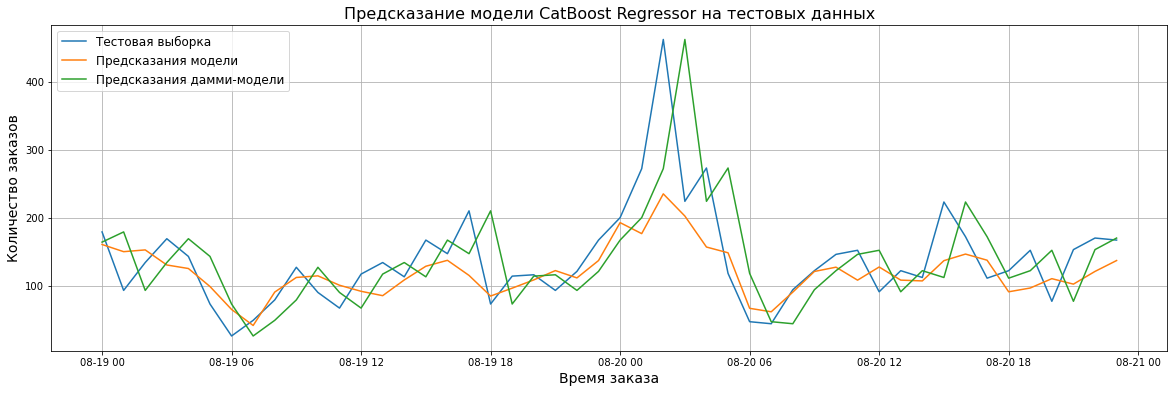

In [51]:
# предсказания модели на тестовой выборке
predict_test_cbr = pd.Series(predict_test_cbr, index=y_test.index)

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

plt.figure(figsize=(20,6))
plt.grid(True)

# легенда
plt.plot(y_test['2018-08-19':'2018-08-20'], label='Тестовая выборка')
plt.plot(predict_test_cbr['2018-08-19':'2018-08-20'], label='Предсказания модели')
plt.plot(pred_previous['num_orders']['2018-08-19':'2018-08-20'], label='Предсказания дамми-модели')

plt.legend(title = '', loc = 'upper left', fontsize = 12)

# заголовок и подписи к осям
plt.xlabel('Время заказа', fontsize=14)
plt.ylabel('Количество заказов',fontsize=14)
plt.title('Предсказание модели CatBoost Regressor на тестовых данных', fontsize = 16)

plt.show()

### Вывод

1. Лучший результат у модели CatBoost Regressor: RMSE = 44
2. На графике видно, что модель в целом CatBoost Regressor хорошо предсказывает количество заказов, ошибки только в пиковых значениях.

### 6.1 Проверим лучшую модель на адекватность:

#### По среднему значению

In [52]:
# рассчитаем rmse по среднему значению
pred_median = np.ones(test.shape[0])*train['num_orders'].mean()
rmse_mean = mean_squared_error(y_test, pred_median)**0.5

In [53]:
pred_median

array([78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 78.451417, 78.451417,
       78.451417, 78.451417, 78.451417, 78.451417, 

#### По предыдущим значениям ряда

In [54]:
# рассчитаем rmse по предыдущему значению
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_previous = mean_squared_error(test, pred_previous)**0.5

In [55]:
print('\033[1m'+ 'Модель "CatBoost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE на тестовой выборке:'+'\033[0m', test_rmse_cbr)
print('='*60)
print('\033[1m'+"Среднее число заказов в день:"+'\033[0m', test['num_orders'].mean())
print('='*60)
print('\033[1m'+"RMSE по среднему значению :"+'\033[0m', rmse_mean)
print('='*60)
print('\033[1m'+"RMSE по предыдущим значениям :"+'\033[0m', rmse_previous)

Модель "CatBoost Regressor"
RMSE на тестовой выборке: 44.09036414273304
Среднее число заказов в день: 139.56136363636364
RMSE по среднему значению : 84.68768287118466
RMSE по предыдущим значениям : 54.25915271312337


RMSE модель "CatBoost Regressor"на тестовой выборке - 44, что меньше RMSE расчитаным по среднему и по предыдущему значениям, значит модель адекватна.

## Вывод

1. Загруженны и изученны исходные данные:
* получены данные по количеству заказов такси за период март - август 2018;
* данные столбца "datetime" переведены в тип данных Datetime, сам столбец установлен как индекс таблицы;
* пропусков в данных нет, временные данные последовательны, частота сбора информации каждые 10 минут;
* для дальнейшей работы данные ресемплированы по 1 часу.

2. Проведена проверка временного ряда на стационарность:
* по тесту Дики-Фуллера данные стационары

3. Данные подготовлены к обучению, разделные на выборки:
* созданы дополнительные признаки для обучения моделей
* выделен целевой признак
* выборки разделены на обучающую и тестовую в соотношении 9:1

4. Были изучены четыре модели, подобраны гиперпараметры на обучающей выборке.

5. Окончательная проверка лучше модели проведена на тестовой выборке.
* все модели показали целевой результат RMSE < 48
* лучшая модель проверена на адекватность двумя способами - адекватна
6. Выбрана лучшая по точности предсказания модель **CatBoost Regressor: RMSE = 44**